# Bidirectional LSTM time series classification 
- Predict Google stock prices given last 10 years of data (2010 - 2020)

- This notebook is inspired by the following tutorials:
    - https://github.com/curiousily/Deep-Learning-For-Hackers/blob/master/03.stock_prediction.ipynb
    - https://machinelearningmastery.com/develop-bidirectional-lstm-sequence-classification-python-keras/
    - https://towardsdatascience.com/predicting-stock-prices-using-a-keras-lstm-model-4225457f0233


# A. Setup

### A.1 Get more ram on google colab

In [1]:
more_ram = True
parameter_search = False
search_best_model = False
gpu= True

In [2]:
# 1. Set run time to GPU
# code to crash colab and get more ram
if not more_ram:
    a = []
    while(1):
        a.append(1)

### A.2 Load libraries and variables


In [3]:
import numpy as np
import pandas as pd

pd.set_option('display.max_columns', 50)

# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
label_col = "Close"
date_col = "Date"
scale_type = "minmax"
features_list = [label_col]
time_steps = 100

# activate GPU
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


### A.3 Fix randomness for reproducible results

In [5]:
# Fix random number for reproducible results
seed_value= 0

import random
random.seed(seed_value)

import numpy as np
np.random.seed(seed_value)

tf.random.set_seed(seed_value)

### A.4 Load dataset

https://finance.yahoo.com/quote/GOOG/history?period1=1568325161&period2=1599947561&interval=1d&filter=history&frequency=1d

- This dataset is obtained from yahoo finance stock price history

In [6]:
import os
data_path = '/content/drive/My Drive/data'
df = pd.read_csv(os.path.join(data_path, 'google_stocks.csv'), parse_dates=[date_col]).sort_values(date_col)

print("Dataframe: ", df.shape)
df.head()

Dataframe:  (2518, 7)


,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-09-13,239.552094,241.270660,238.869659,240.234543,240.234543,4499700
1,2010-09-14,240.105026,241.469910,239.143631,239.317978,239.317978,4449500
2,2010-09-15,239.078873,240.045258,238.356583,239.422592,239.422592,4823600
3,2010-09-16,239.078873,240.324203,238.809875,239.631805,239.631805,3953700
4,2010-09-17,240.971771,244.682861,239.691574,244.159836,244.159836,11325400


### A.4 Data exploration

In [7]:
def plot_timeseries_label(df: pd.DataFrame, date_col: str, label_col: str, y_label_name = "Close Price (USD)"):
    """
    Plot time series label of interest (Eg. change in close prices of stock over time)

    Inputs:
    - df: dataframe of data
    - date_col: col name of date
    - label_col: col name of label
    - y_label_name: name of label axis, defaults to "Close Price (USD)"
    """
    ax = df.plot(x=date_col, y=label_col);
    ax.set_xlabel(date_col)
    ax.set_ylabel(y_label_name)

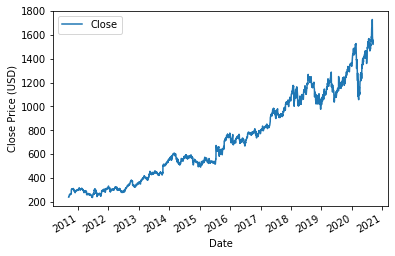

In [8]:
plot_timeseries_label(df, date_col, label_col)

### A.5 Data splits

- Train data: ~1-6 years
- val data: 6-7 years
- Test data: ~7-10 years

In [9]:
# get year column
df["year"] = df[date_col].dt.date
df["year"] = df["year"].apply(lambda val: val.year)

start_year = min(df["year"].values)
end_year = max(df["year"].values)
duration = end_year - start_year

print("start_year: ", start_year)
print("end_year: ", end_year)
print("duration: ", duration)

start_year:  2010
end_year:  2020
duration:  10


In [10]:
train_df = df.loc[df["year"].isin(list(range(start_year, start_year + 6)))]
val_df = df.loc[df["year"] == start_year+7 ]
test_df = df.loc[df["year"].isin(list(range(start_year + 8, end_year)))]

print("train_df= " , train_df.shape)
print("val_df= " , val_df.shape)
print("test_df= " , test_df.shape)

train_df=  (1336, 8)
val_df=  (251, 8)
test_df=  (503, 8)


## B. Data Processing

https://towardsdatascience.com/feature-engineering-for-machine-learning-3a5e293a5114

Things to consider:
- Data imputation / missing values
- Handling outliers
    - detect and remove
    - detect and capp 
- Log transform:
    - helps to handle skewed data and after transformation, the distribution becomes more approximate to normal.
    - In most of the cases the magnitude order of the data changes within the range of the data. For instance, the difference between ages 15 and 20 is not equal to the ages 65 and 70. In terms of years, yes, they are identical, but for all other aspects, 5 years of difference in young ages mean a higher magnitude difference. This type of data comes from a multiplicative process and log transform normalizes the magnitude differences like that.
    - It also decreases the effect of the outliers, due to the normalization of magnitude differences and the model become more robust.
    - NOTE: The data you apply log transform must have only positive values, otherwise you receive an error. Also, you can add 1 to your data before transform it. Thus, you ensure the output of the transformation to be positive.
- One-hot-encoding:
    - This method changes your categorical data, which is challenging to understand for algorithms, to a numerical format and enables you to group your categorical data without losing any information.
- Scaling:
    - makes sure different scales don't affect model

### B.2 Feature scaling 


https://machinelearningmastery.com/normalize-standardize-time-series-data-python/
https://www.analyticsvidhya.com/blog/2020/04/feature-scaling-machine-learning-normalization-standardization/

Scaling features:
- purpose: Having features on a similar scale can help the gradient descent converge more quickly towards the minima.
- distance based algorithms: we scale our data before employing a distance based algorithm so that all the features contribute equally to the result. 

Types of scalers:
https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html
- StandardScaler: removes the mean and scales the data to unit variance
    - outliers have an influence when computing the empirical mean and standard deviation which shrink the range of the feature values
    - cannot guarantee balanced feature scales in the presence of outliers
- minmax scaler: normalizing to [0,1], sensitive to outliers
- maxabs scaler: absolute values scaled to [0,1], sensitive to outliers
- robust scaler: the centering and scaling statistics based on percentiles
    - not influenced by a few number of very large marginal outliers. 
    - resulting range of the transformed feature values is larger and are approximately similar. 
    - Outliers themselves are still present in the transformed data
- power transformer: applies a power transformation to each feature to make the data more Gaussian-like. 
    - Currently, PowerTransformer implements the Yeo-Johnson and Box-Cox transforms
    -  finds the optimal scaling factor to stabilize variance and mimimize skewness through maximum likelihood estimation

- QuantileTransformer: 
    - has an additional output_distribution parameter allowing to match a Gaussian distribution instead of a uniform distribution. Note that this non-parametetric transformer introduces saturation artifacts for extreme values
    - also can apply a non-linear transformation such that the probability density function of each feature will be mapped to a uniform distribution. In this case, all the data will be mapped in the range [0, 1], even the outliers which cannot be distinguished anymore from the inliers
    - robust to outliers in the sense that adding or removing outliers in the training set will yield approximately the same transformation on held out data. But contrary to RobustScaler, QuantileTransformer will also automatically collapse any outlier by setting them to the a priori defined range boundaries (0 and 1).

- normalizer:
    - rescales the vector for each sample to have unit norm, independently of the distribution of the samples


In [11]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer

def fit_scaler(train_df, features_list: list, scale_type: str):
    """
    Fit scaler on train data
    inputs:
    - train_df: dataframe of x train data
    - features_list: list of features to be scaled
    - scale_type: type of scale to use (ie. standardize, normalize)

    scalers takes input (num_samples, num_features) and scales all features
    """
    scaler_dict = {
        "standard" : StandardScaler(), 
        "minmax" : MinMaxScaler(feature_range=(0, 1)) , 
        "maxabs" : MaxAbsScaler(), 
        "robust": RobustScaler(quantile_range=(25, 75)),
        "power_yeo_johnson": PowerTransformer(method='yeo-johnson'),
        "power_box_cox" : PowerTransformer(method='box-cox'),
        "quartile_normal":  QuantileTransformer(output_distribution='normal'),
        "quartile_uniform": QuantileTransformer(output_distribution='uniform'),
        "normalizer": Normalizer()
    }
    
    scaler = scaler_dict[scale_type].fit(train_df[features_list])

    return scaler

In [12]:
# Fit the standardized scaler on the TRAIN data
scaler = fit_scaler(train_df, features_list, scale_type)

# Tranform both TRAIN and TEST data on the scaler fitted on TRAIN data
train_df[features_list] = scaler.transform(train_df[features_list])
val_df[features_list] = scaler.transform(val_df[features_list])
test_df[features_list] = scaler.transform(test_df[features_list])

print("train: ", train_df.shape)
print("val: ", val_df.shape)
print("test: ", test_df.shape)
test_df.head()

train:  (1336, 8)
val:  (251, 8)
test:  (503, 8)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

,Date,Open,High,Low,Close,Adj Close,Volume,year
1839,2018-01-02,1048.339966,1066.939941,1045.229980,1.534028,1065.000000,1237600,2018
1840,2018-01-03,1064.310059,1086.290039,1063.209961,1.566396,1082.479980,1430200,2018
1841,2018-01-04,1088.000000,1093.569946,1084.001953,1.573654,1086.400024,1004600,2018
1842,2018-01-05,1094.000000,1104.250000,1092.000000,1.602966,1102.229980,1279100,2018
1843,2018-01-08,1102.229980,1111.270020,1101.619995,1.611688,1106.939941,1047600,2018


### B.3 Check for NaN values

In [13]:
def check_nan(df: pd.DataFrame, features_list: list):
    """
    Check for which features have nan values
    """
    features = []
    for feature in features_list:
        vals = df[feature].values
        if np.isnan(np.sum(vals)):
            features.append(feature)
    
    return features

In [14]:
# Check to see if there are any nan values in any features
    # nan values will be ignored/masked by lstm model
print("train: %d" %len(check_nan(train_df, features_list)))
print("val: %d" %len(check_nan(val_df, features_list)))
print("test: %d" % len(check_nan(test_df, features_list)))

train: 0
val: 0
test: 0


## C. Bidirectional LSTM model

https://machinelearningmastery.com/develop-bidirectional-lstm-sequence-classification-python-keras/

- Bidirectional LSTM: 
    - involves duplicating the first recurrent layer in the network so that there are now two layers side-by-side, then providing the input sequence as-is as input to the first layer and providing a reversed copy of the input sequence to the second.
    - Where LSTM learns linearly, Bidirectional LSTM learns from both past and future to predict current


    


### C.1 Prepare data format for LSTM model
https://machinelearningmastery.com/reshape-input-data-long-short-term-memory-networks-keras/

Input dimensions:
- Samples. One sequence is one sample. A batch is comprised of one or more samples.
- Time Steps. One time step is one point of observation in the sample.
- Features. One feature is one observation at a time step.

- model by default expects 1 or more samples
- input_shape = (num_time_steps, num_features)

x_train data shape: data.reshape(num_samples, num_time_steps, num_features)

num_time_steps = 70
num_features = 9

In [15]:
import torch
from torch.utils.data import DataLoader, Dataset

class LSTMDataset(Dataset):
    def __init__(self, df:pd.DataFrame, features_list, date_col, time_steps):
        self.df = df
        self.features_list = features_list
        self.date_col = date_col
        self.time_steps = time_steps
        self.data, self.labels = self.prepare_data(df, features_list, date_col, time_steps)

    
    def get_valid_feature_values(self, df: pd.DataFrame, features_list:list, date_col : str):
        """
        Remove convert all invalid values (infinity, None, 'None') to np.nan (so that it can be masked)
        Return feature values as np.array given features of interset (features_list)

        Input:
        - df: dataframe of feature data per uid
        - features_list: list of features to keep 
        """
        # convert +- inf to np.nan
        df = df.replace([np.inf, -np.inf], np.nan)

        # convert "None" to np.nan
        df = df.replace(to_replace="None", value=np.nan)

        # convert None with np.nan
        df.fillna(value=np.nan, inplace=True)

        df = df.sort_values(by=[date_col])

        return df[features_list].values

    def prepare_data(self, df: pd.DataFrame, features_list: list, date_col: str, time_steps: int):
        """
        Preparing data for CNN

        Inputs:
        df: dataframe of data (train or test)
        uids: uids that correspond to the labels, in correct order
        y: corresponding labels
        features_list: list of features to keep
        time_steps:  number of time_steps, default to 100

        Outputs:
        X data: (num_samples, num_time_steps, num_features)
        y data: (num_samples, )
        """
        
        data = self.get_valid_feature_values(df, features_list, date_col)
        X_data = []
        y_data = []

        # Rolling window sequence, moves up by 1 data point every time
        for i in range(time_steps, len(data)):
            # Get sequence of length time_steps up till current i - 1
            X_data.append(data[i - time_steps : i])

            # Get stock price at i (label to predict)
            y_data.append(data[i])


        X_data, y_data = np.array(X_data), np.array(y_data)
        X_data = X_data.reshape(len(X_data), time_steps, len(features_list))

        y_data = y_data.reshape(len(y_data))
        
        return X_data, y_data 
    
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, index):
        """
        X[index] = (time_steps, num_timesteps, features)
        Y[index] = (1)
        """
        X = self.data[index]
        y = self.labels[index].reshape(1)
        return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


In [16]:
# test dataset
dataset = LSTMDataset(train_df, features_list, date_col, time_steps)
print(dataset.data.shape)
print(dataset.labels.shape)

(1236, 100, 1)
(1236,)


### C.2 Define pytorch LSTM model

In [17]:
import torch
from torch import optim, nn
import pdb

class LSTM(nn.Module):

    def __init__(self, gpu:bool, num_features, hidden_size, num_layers, output_dim, device, is_bidirectional, dr=0.2):
        """
        - num_features: number of features for input
        - hidden_size: number of features for hidden state
        - num_layers: number of recurrent layers (ie. number of LSTM layers)
        - output_size: number of classes to predict
        """
        super(LSTM, self).__init__()

        self.gpu = gpu
        self.num_features = num_features
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.device = device
        # output_dim set to 1 = predict 1 value
        self.output_dim = output_dim
        self.is_bidirectional = is_bidirectional

        # LSTM layers
            # If your input data is of shape (batch_size, time_steps, features) then you need batch_first=True 
            # If your input data is (time_steps, batch_size, features), then you don't need batch_first=True
        self.lstm = nn.LSTM(input_size=num_features, hidden_size=hidden_size, num_layers=num_layers, batch_first = True, bidirectional= is_bidirectional)
        self.dropout = nn.Dropout(p = dr)

        if self.is_bidirectional:
            # Linear classification with 1 class = regression prediction from 0 to 1
            self.fc = nn.Linear(hidden_size * 2, self.output_dim)
        
        else:
            # Linear classification with 1 class = regression prediction from 0 to 1
            self.fc = nn.Linear(hidden_size, self.output_dim)

    def forward(self, x):
        # x = (batch_size, time_steps num_features) = (batch_size, 100, 1)
        # reset state of LSTM
        h0, c0 = self.init_hidden(x)

        # feed data and hidden states of this batch
        # out = (batch_size, time_steps, hidden_layers) = [16, 100, 2] 
        out, (hn, cn) = self.lstm(x, (h0, c0))
        out = self.dropout(out)

        # out = (batch_size, time_steps, output_dim) = [16, 100, 1] 
        out = self.fc(out)

        # out = (batch_size, output_dim) = [16, 1]
            # get output from the last time step = represent the next prediction
        out = out[:,-1,:]

        return out

    def init_hidden(self, x):
        # return zeros 
            # size = (num_layers, batch_size, num_hidden_layers) = [1, 16, 2]
            # ie. for each layer, you have hidden states (= num of hidden layers) for each sample in batch.
        
        if self.is_bidirectional:
            h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size)
            c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size)

        else:
            h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
            c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)

        if self.gpu:
            return [t.to(self.device) for t in (h0, c0)]
        else:
            return [t for t in (h0, c0)]


### C.3 Train and evalute model on train and val

In [18]:
class AverageMeter(object):
    """
    Function to calculate loss and accuracy during training
    """
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [19]:
import pdb

def train(train_loader, optimizer, criterion, model, device):
    """
    Train model for every batch in sample for this current epoch
    """
    # set model to train mode
    model.train()

    train_loss = AverageMeter()

    # go through every batch for this current epoch
    for i, (x_batch, y_batch) in enumerate(train_loader):
        # pdb.set_trace()

        # x_batch = (batch_size, time_step, num_features) = (16, 100, 1)
        x_batch = x_batch.to(device)
        # y_batch = (batch_size, num_features) = (16, 1)
        y_batch = y_batch.to(device)
        N = x_batch.size(0)
        
        # Set gradients to zero before starting to do back propagation because pytorch accumulates the gradients on subsequent backward passes
        optimizer.zero_grad()

        # y_scores = (batch_size, output_dim) = [16, 1]
        y_scores = model(x_batch)

        loss = criterion(y_scores, y_batch)
        loss.backward()
        optimizer.step()

        train_loss.update(loss.item())

    # return average train loss for epoch
    return train_loss.avg

In [20]:
def validate(val_loader, optimizer, criterion, model, device):
    """
    Validate trained model on validation dataset for this epoch
    """
    # set model to eval mode
    model.eval()
    val_loss = AverageMeter()

    # stop gradient descent / back prop during evaluation
    with torch.no_grad():
        for i, (x_batch, y_batch) in enumerate(val_loader):
            # x_batch = (batch_size, time_step, num_features) = (16, 100, 1)
            x_batch = x_batch.to(device)
            # y_batch = (batch_size, num_features) = (16, 1)
            y_batch = y_batch.to(device)
            N = x_batch.size(0)

            # y_scores = (batch_size, output_dim) = [16, 1]
            y_scores = model(x_batch)
            loss = criterion(y_scores, y_batch)

            val_loss.update(loss.item())
    
    return val_loss.avg

In [21]:
import tqdm
from tqdm import tqdm

def run_model(train_loader, val_loader, optimizer, criterion, model, device, data_path, patience, num_epochs, model_name):
    """
    Train and evaluate per epoch and visualize loss over time
    """
    best_loss = float('inf')
    train_losses = []
    val_losses = []
    epochs_trained = num_epochs
    best_model = None

    for epoch in range(1, num_epochs + 1): 
        loss_train = train(train_loader, optimizer, criterion, model, device)
        loss_val = validate(val_loader, optimizer, criterion, model, device)

        train_losses.append(loss_train)
        val_losses.append(loss_val)

        print("epoch: ", epoch, "train loss: ", loss_train, "val_loss: ", loss_val)

        # if lowest loss, save model
        if loss_val < best_loss:
            best_loss = loss_val
            es = 0
            torch.save(model.state_dict(), data_path + model_name)
            best_model = model

        # if loss is not going down
        else:
            # patience count
            es +=1

            if es > patience:
                epochs_trained = epoch
                print("Early stopping with lowest loss: ", best_loss)
                break

    return train_losses, val_losses, epochs_trained, best_model


In [37]:
import matplotlib.pyplot as plt

def run_LSTM(is_bidirectional:bool, num_epochs = 1000, patience = 5, learning_rate = 0.01, num_layers = 1, num_features = 1, hidden_size = 2, output_dim = 1, model_name = "lstm_model_stocks.pt"):
    """
    Run and evaluate LSTM model
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = LSTM(gpu, num_features, hidden_size, num_layers, output_dim, device, is_bidirectional)
    model.to(device)

    # optimizer = adam
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

    # loss = MSELoss for regression
    criterion = torch.nn.MSELoss()

    # data loader:
    train_loader = DataLoader(dataset = LSTMDataset(train_df, features_list, date_col, time_steps), shuffle = False, batch_size = 32)
    val_loader = DataLoader(dataset = LSTMDataset(val_df, features_list, date_col, time_steps), shuffle = False, batch_size = 32)

    # run train and evaluation = save best model
    train_losses, val_losses, epochs_trained, best_model = run_model(train_loader, val_loader, optimizer, criterion, model, device, data_path, patience, num_epochs, model_name)

    # plot train and val losses
    epochs = list(range(1, epochs_trained + 1))
    plt.plot(epochs, train_losses, 'g', label='Training loss')
    plt.plot(epochs, val_losses, 'b', label='validation loss')
    plt.title('Training and Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    return best_model


epoch:  1 train loss:  0.4721220315266878 val_loss:  0.8319904565811157
epoch:  2 train loss:  0.09160593390846863 val_loss:  0.6263182044029236
epoch:  3 train loss:  0.06447628715959115 val_loss:  0.4752460539340973
epoch:  4 train loss:  0.047335161946904965 val_loss:  0.3662232518196106
epoch:  5 train loss:  0.03969361802610832 val_loss:  0.2953947216272354
epoch:  6 train loss:  0.026858896686462685 val_loss:  0.24851177930831908
epoch:  7 train loss:  0.02567880407635433 val_loss:  0.21500654220581056
epoch:  8 train loss:  0.027961757520619683 val_loss:  0.19101183116436005
epoch:  9 train loss:  0.023239222998456217 val_loss:  0.18277880251407624
epoch:  10 train loss:  0.026417375412375595 val_loss:  0.18320620954036712
epoch:  11 train loss:  0.0218444233506512 val_loss:  0.18183617889881135
epoch:  12 train loss:  0.023801683360197317 val_loss:  0.17354550063610077
epoch:  13 train loss:  0.019885517220991928 val_loss:  0.16516285836696626
epoch:  14 train loss:  0.01900404

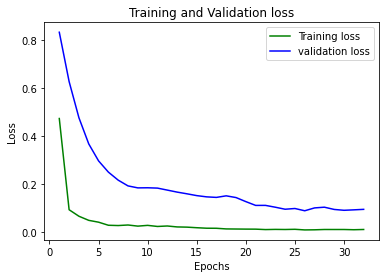

In [38]:
lstm_model = run_LSTM(is_bidirectional = False)

epoch:  1 train loss:  0.019467583424650516 val_loss:  0.5050675928592682
epoch:  2 train loss:  0.05861116083673178 val_loss:  0.19809814691543579
epoch:  3 train loss:  0.04198145116858471 val_loss:  0.07608466148376465
epoch:  4 train loss:  0.009976671960873481 val_loss:  0.06603458523750305
epoch:  5 train loss:  0.006817717072315132 val_loss:  0.09803748428821564
epoch:  6 train loss:  0.007548248938595255 val_loss:  0.05977053120732308
epoch:  7 train loss:  0.006545071072207811 val_loss:  0.04979940876364708
epoch:  8 train loss:  0.005734552748692341 val_loss:  0.04908056259155273
epoch:  9 train loss:  0.006441203615395352 val_loss:  0.026317591220140456
epoch:  10 train loss:  0.005703952150025333 val_loss:  0.024120893515646457
epoch:  11 train loss:  0.005954485744811022 val_loss:  0.059688425809144977
epoch:  12 train loss:  0.006738628013035617 val_loss:  0.06230193302035332
epoch:  13 train loss:  0.006685435165985463 val_loss:  0.03850160352885723
epoch:  14 train loss

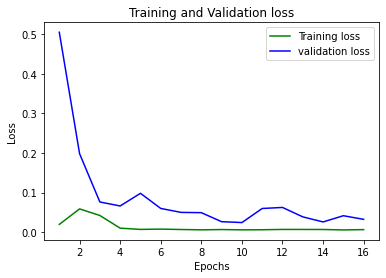

In [39]:
bi_lstm_model = run_LSTM(is_bidirectional = True)

### C.3 Evalute trained models on val dataset

In [33]:
def evaluate_model(data_loader, model):
    model.eval()
    criterion = torch.nn.MSELoss()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    test_loss = AverageMeter()
    y_scores = []
    y_trues = []

    for data, y_true in data_loader:
        # data = (1, time_steps, num_features) =  [1, 100, 1]
        data = data.to(device)
        # y_true = (1, num_features) = [1,1]
        y_true = y_true.to(device)

        y_score = lstm_model(data)
        y_scores.append(y_score)
        y_trues.append(y_true)

        loss = criterion(y_score, y_true)
        test_loss.update(loss.item())

    print("loss: ", test_loss.avg)

    return np.asarray(y_scores), np.asarray(y_trues)

In [30]:
def graph_predictions(y_scores, y_trues):
    # plot train and val losses
    time_array = range(1, len(y_scores)+1)

    plt.plot(time_array, y_scores, 'g', label='Prediction')
    plt.plot(time_array, y_trues, 'b', label='Truth')
    plt.title('Stock price prediction')
    plt.xlabel('Time steps')
    plt.ylabel('Price')
    plt.legend()
    plt.show()
    

loss:  0.090408989949929


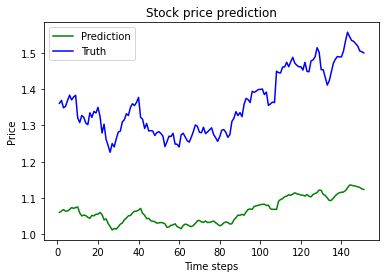

In [40]:
val_loader = DataLoader(dataset = LSTMDataset(val_df, features_list, date_col, time_steps), shuffle = False)

# Test lstm_model on val dataset
y_scores, y_trues = evaluate_model(val_loader, lstm_model)
graph_predictions(y_scores, y_trues)

loss:  0.090408989949929


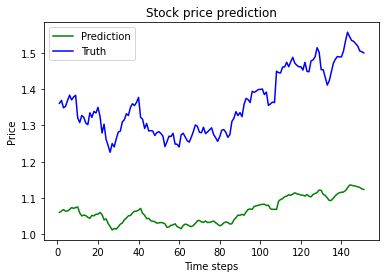

In [41]:
# Test lstm_model 
y_scores, y_trues = evaluate_model(val_loader, bi_lstm_model)
graph_predictions(y_scores, y_trues)

### C.4 Evalute trained models on test dataset

loss:  0.30052152057883164


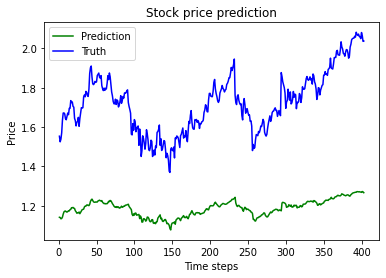

In [43]:
test_loader = DataLoader(dataset = LSTMDataset(test_df, features_list, date_col, time_steps), shuffle = False)

# Test lstm_model 
y_scores, y_trues = evaluate_model(test_loader, lstm_model)
graph_predictions(y_scores, y_trues)

loss:  0.30052152057883164


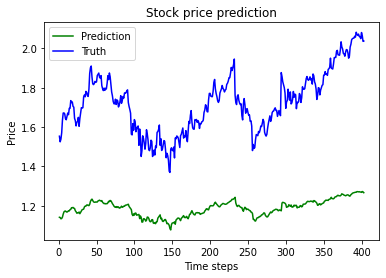

In [44]:
# Test bi-lstm model
y_scores, y_trues = evaluate_model(test_loader, lstm_model)
graph_predictions(y_scores, y_trues)